In [1]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import json
import os
import math
import heapq
import seaborn as sns
import matplotlib.pyplot as plt
import csv

import random

In [2]:
cwd = os.getcwd()
print(cwd)

/Users/m1m1024/Desktop/cs330/cs330-casestudy


# Load Data

In [3]:
with open(f'{cwd}/adjacency 2.json') as adjacency_f:
    adjacency = json.load(adjacency_f)
    
with open(f'{cwd}/node_data.json') as node_f:
    nodes = json.load(node_f)

# Functions

In [4]:
def haversine_distance(lat1, lon1, lat2, lon2):
    '''
    Haversine distance metric between two points
    '''
    
    #earth radius in km
    radius = 6371.0

    #convert lat lon into radians from degress
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    #haversine from wikipedia
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = radius * c

    return distance

In [5]:
class Node:
    def __init__(self, point, left=None, right=None):
        self.point = point
        self.left = left
        self.right = right

class KDTree:
    def __init__(self, points):
        self.root = self._build_kdtree(points)

    def _build_kdtree(self, points, depth=0):
        if not points:
            return None

        axis = depth % 2  # 2 dimensions (alternating between latitude and longitude)

        sorted_points = sorted(points, key=lambda point: point[axis])
        median = len(sorted_points) // 2

        return Node(
            sorted_points[median],
            self._build_kdtree(sorted_points[:median], depth + 1),
            self._build_kdtree(sorted_points[median + 1 :], depth + 1),
        )

    def find_nearest(self, target):
        best = [None, float("inf")]

        def search(node, depth=0):
            if node is None:
                return

            axis = depth % 2
            current_point = node.point
            distance = haversine_distance(current_point[0], current_point[1], target[0], target[1])

            if distance < best[1]:
                best[0] = current_point
                best[1] = distance

            if target[axis] < current_point[axis]:
                search(node.left, depth + 1)
            else:
                search(node.right, depth + 1)

            other_side = abs(target[axis] - current_point[axis])
            if other_side < best[1]:
                if target[axis] < current_point[axis]:
                    search(node.right, depth + 1)
                else:
                    search(node.left, depth + 1)

        search(self.root)
        return best[0]

coordinates = [(node_info['lat'], node_info['lon']) for node_info in nodes.values()]
coordinate_to_key = {coord: key for key, coord in zip(nodes.keys(), coordinates)}
kdtree = KDTree(coordinates)


In [6]:
def get_datetime(time_string):
    '''
    Convert any datetime strings to datetime
    '''
    datetime_format = "%m/%d/%Y %H:%M:%S"
    time = datetime.strptime(time_string, datetime_format)
    return time

In [7]:
def heuristic_estimate(source, dest):
    return haversine_distance(source['lat'], source['lon'], dest['lat'], dest['lon'])

In [8]:
def a_star(source, dest, dt, day_type):
    '''
    A* search algorithm
    Returns: dict of minimum distances to nodes and dict of node parents
    '''

    distance = {}
    parent = {}
    hour = dt.hour

    for node in nodes:
        distance[node] = float('inf')
    distance[source] = 0
    pq = [(heuristic_estimate(nodes[source], nodes[dest]), 0, source)] #pq with (priority, actual cost, node)
    
    while pq:
        _, node_dist, node = heapq.heappop(pq)
        if node == dest:
            break
        if node in adjacency:
            for neighbor in adjacency[node]:
                for edge in adjacency[node][neighbor]:
                    if edge['hour'] == hour and edge['day_type'] == day_type:
                        edge_dist = edge['time']
                        if distance[neighbor] > node_dist + edge_dist:
                            distance[neighbor] = node_dist + edge_dist
                            parent[neighbor] = node
                            priority = distance[neighbor] + heuristic_estimate(nodes[neighbor], nodes[dest])/20
                            heapq.heappush(pq, (priority, distance[neighbor], neighbor))

    return distance, parent

In [9]:
def get_path(parent, source_node, dest_node):
    '''
    Recover path using list of node parents, start at destination and end at source
    Returns: list of nodes in path (reverse order)
    '''
    path = [dest_node]
    current_node = dest_node
    while current_node != source_node:
        path.append(parent[current_node])
        current_node = parent[current_node]
    return path

In [10]:
def get_driver(p, dt, day_type, start_time):
    '''
    Get the next driver from the driver PQ (Task 3 based on estimated time)
    Update relevant driver and passenger variables and get the time to traverse from driver location to passenger pickup
    Returns: Driver match
    '''
    p.total_time = 0
    d_match_tuple = None #(driver available, id, driver object)
    d_match = None #driver
    pickup_time = float('inf')
    availablesize = 0
    all_potential_candidates = []
    
    while driver_q:
        d_candidate = heapq.heappop(driver_q) #(datetime, id, driver object)
        d_time, idx, d = d_candidate
        if d_time <= start_time: #is available
            availablesize += 1
            if check_active(start_time, d): #driver active or been sitting for too long
                all_time_est, _ = a_star(d.current_node, p.source_node, p.appear, day_type)
                time_est = all_time_est[p.source_node]
                if time_est < pickup_time: #if better match
                    pickup_time = time_est
                    if d_match_tuple:
                        all_potential_candidates.append(d_match_tuple)
                        # heapq.heappush(driver_q, d_match_tuple) #put current match back into q
                    d_match = d
                    d_match_tuple = d_candidate
                else:
                    all_potential_candidates.append(d_candidate)
                    # heapq.heappush(driver_q, d_candidate) #not a better match, put back in q
            else:
                completed_drivers.append(d)
                driver_profits.append(d.get_profit())
        else:
            #push back to heap since not actually available yet
            heapq.heappush(driver_q, (d_time, d.idx, d))
            break
    for i in range(len(all_potential_candidates)):
           heapq.heappush(driver_q, all_potential_candidates[i])
        
    wait_time = 0
    if d_match is None: #check if no match found (no drivers available), choose next available
        available_time, idx, d_match = heapq.heappop(driver_q) #(datetime, id, driver object) 
        time_diff = available_time - p.appear
        wait_time = time_diff.total_seconds()/3600 #get number of hours passenger has to wait for next driver to be available
        all_time_est, _ = a_star(d_match.current_node, p.source_node, p.appear, day_type)
        pickup_time = all_time_est[p.source_node]

    with open('driver_order.txt', 'a') as file:
            file.write(f"Driver {d_match.idx}: matched with passenger {p.idx} and available driver # is {availablesize} \n")

    p.total_time += wait_time
    d_match.current_node = p.source_node
    d_match.pickup_time += pickup_time
    p.total_time += pickup_time
    with open('pwaittime.txt', 'a') as file:
        file.write(f"passenger {p.idx}: waiting {p.total_time} \n")
    return d_match, pickup_time + wait_time

In [11]:
# def check_active(current_time, d):
#     driver_leaves = 0.8
#     val = random.random()
#     if val < driver_leaves:
#         with open('driver_order.txt', 'a') as file:
#             file.write(f"Driver {d.idx}: still in queue \n")
#         return True #still active
#     else:
#         with open('driver_order.txt', 'a') as file:
#             file.write(f"Driver {d.idx}: exited \n")
#         return False #driver is inactive
def check_active(current_time, d):
    if d.ride_time != 0:
        max_active_time = timedelta(hours=8) #check if driver has been active for over 8 hours, reference passenger appear for current time
        time_active = current_time - d.appear
        
        
        probability = 0.0

        if time_active >= max_active_time:
            probability = 1.0

        # Calculate probability based on hours active
        else:
            hours_active = time_active.total_seconds() / 3600  # Convert to hours
            probability = hours_active / 5


        if random.random() < probability:
            with open('driver_order4.txt', 'a') as file:
                file.write(f"Driver {d.idx}: exited the queue \n")
            return False
        else:
            with open('driver_order4.txt', 'a') as file:
                file.write(f"Driver {d.idx}: still in queue \n")
            return True
    else:
        return True

In [24]:
def ride():
    '''
    Main function for going through passenger and driver queues
    '''

    global passenger_index
    global day_type
    global pass_time
    global current_time
    
    while passenger_index < len(passenger_q) and driver_q:
        _, _, p = passenger_q[passenger_index]  #(datetime, id, passenger object)
        updated_to_weekend = False
        if p.appear - start_time >= timedelta(hours=24) and not updated_to_weekend:
            with open('activity_log.txt', 'a') as file:
                file.write(f"time updated to weekend from this passenger: {p.idx} and {p.appear} \n")
            day_type = 'weekend'
            updated_to_weekend = True
            
        
        d, pickup_time = get_driver(p, p.appear, day_type, pass_time)
        current_time = p.appear + timedelta(hours=pickup_time) 
        pass_time = p.appear + timedelta(hours=pickup_time) #account for time to pickup
        
        time, parent = a_star(p.source_node, p.dest_node, current_time, day_type)
        ride_time = time[p.dest_node]
        p.total_time += ride_time
        completed_passengers.append(p)
        passenger_times.append(p.total_time)
        d.source_node = p.dest_node
        d.source = p.dest
        d.ride_time += ride_time
        
        if math.isfinite(p.total_time):
            current_time = timedelta(hours=ride_time) + current_time
        passenger_index += 1
        if check_active(current_time, d):
            heapq.heappush(driver_q, (current_time, d.idx, d))
       
        else:
            completed_drivers.append(d)
            driver_profits.append(d.get_profit())
    
    while driver_q:
        _, _, d = heapq.heappop(driver_q)
        completed_drivers.append(d)
        driver_profits.append(d.get_profit())
        
    return completed_passengers, completed_drivers, passenger_times, driver_profits

# Classes (Driver, Passenger)

In [14]:
class driver:
    def __init__(self, index, appear, source_lat, source_lon):
        self.idx = index
        self.appear = get_datetime(appear)
        self.source = (source_lat, source_lon)
        self.ride_time = 0 #total time logged driving passengers
        self.pickup_time = 0 #total time logged driving to passengers
        self.source_node = coordinate_to_key.get(kdtree.find_nearest((self.source[0], self.source[1])))
        self.current_node = self.source_node #update as performing routes

    def get_profit(self):
        self.profit = self.ride_time - self.pickup_time
        return self.profit

In [15]:
class passenger:
    def __init__(self, index, appear, source_lat, source_lon, dest_lat, dest_lon):
        self.idx = index
        self.appear = get_datetime(appear)
        self.source = (source_lat, source_lon)
        self.dest = (dest_lat, dest_lon)
        self.total_time = 0 #total time logged for passenger (time appear to time drop off)
        self.source_node = coordinate_to_key.get(kdtree.find_nearest((self.source[0], self.source[1])))
        self.dest_node = coordinate_to_key.get(kdtree.find_nearest((self.dest[0], self.dest[1])))

# Run Task 4

### Initialize Passenger Queue

In [16]:
passenger_q = []

with open(f'{cwd}/passengers.csv', 'r') as csvfile:
    reader_variable = csv.reader(csvfile, delimiter=",")
    first_line = csvfile.readline()
    for index, row in enumerate(reader_variable):
        p = passenger(index, row[0], float(row[1]), float(row[2]), float(row[3]), float(row[4]))
        passenger_q.append((p.appear, p.idx, p))

#### Verification that nodes are correct for passengers

In [17]:
def check_for_none(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    none_lines = []
    for line_num, line in enumerate(lines, start=1):
        if "None" in line:
            none_lines.append(f"Found 'None' on line {line_num}: {line.strip()}")

    return none_lines

def check_for_diff(file1_path, file2_path):
    differences_found = False
    with open(file1_path, 'r') as file1, open(file2_path, 'r') as file2:
        lines1 = file1.readlines()
        lines2 = file2.readlines()

    # check for differences in start and dest nodes
    for line1, line2 in zip(lines1, lines2):
        # extract start and dest nodes from both lines
        start1 = line1.split('start: ')[1].split(' dest: ')[0].strip()
        dest1 = line1.split('dest: ')[1].strip()
        
        start2 = line2.split('start: ')[1].split(' dest: ')[0].strip()
        dest2 = line2.split('dest: ')[1].strip()

        # compare the two nodes
        if start1 != start2 or dest1 != dest2:
            differences_found = True
            print("Difference found:")
            print("File 1:", line1.strip())
            print("File 2:", line2.strip())
            print()

    return differences_found



In [18]:
file_path = 'passenger_sanity_check.txt'

with open(file_path, 'w') as file:
    for passenger in passenger_q:
        file.write('start: '+str(passenger[2].source_node) +'   dest: '+ str(passenger[2].dest_node) + '\n')


result = check_for_none(file_path)
if result:
    print("Lines containing 'None':")
    for line in result:
        print(line)
else:
    print("No lines containing 'None' found.")

# result = check_for_diff('passenger_sanity_check.txt', 'passenger_brute_force.txt')
# if not result:
#     print('Im him')


No lines containing 'None' found.


### Initialize Driver Priority Queue

In [19]:
driver_q = []

with open(f'{cwd}/drivers.csv', 'r') as csvfile:
    reader_variable = csv.reader(csvfile, delimiter=",")
    first_line = csvfile.readline()
    for index, row in enumerate(reader_variable):
        d = driver(index, row[0], float(row[1]), float(row[2]))
        driver_q.append((d.appear, d.idx, d))
        
heapq.heapify(driver_q)

#### Verification that nodes are correct for Driver Queue

In [20]:
file_path = 'driver_sanity_check.txt'

with open(file_path, 'w') as file:
    for driver in driver_q:
        file.write('start: '+str(driver[2].source_node) + '\n')


result = check_for_none(file_path)
if result:
    print("Lines containing 'None':")
    for line in result:
        print(line)
else:
    print("No lines containing 'None' found.")

No lines containing 'None' found.


In [25]:
completed_passengers = []
completed_drivers = []
passenger_times = []
driver_profits = []
day_type = 'weekday'
start_time = passenger_q[0][0]
current_time = start_time
pass_time = start_time
passenger_index = 0  # Track the passenger queue index

completed_passengers, completed_drivers, passenger_times, driver_profits = ride()

In [26]:
file_path = 'passenger_times.txt'

# Open the file in write mode
with open(file_path, 'w') as file:
    # Write each value in passenger_times list to the file
    for time in passenger_times:
        file.write(str(time) + '\n')


file_path = 'driver_profits.txt'

# Open the file in write mode
with open(file_path, 'w') as file:
    # Write each value in driver profist list to the file
    for profit in driver_profits:
        file.write(str(profit) + '\n')

print(sum(passenger_times)/len(passenger_times))
print(sum(driver_profits)/len(driver_profits))


1.4777804008813369
0.3385439472001031


<Axes: ylabel='Count'>

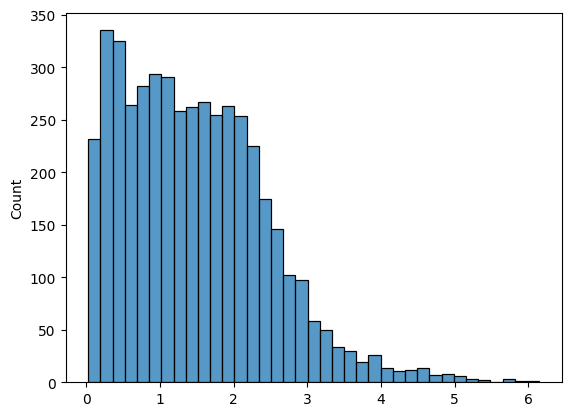

In [27]:
sns.histplot(passenger_times)

In [ ]:
sns.histplot(driver_profits)

# A* Test
Single passenger and single driver

In [ ]:
nodes_df = pd.DataFrame(nodes).T
nodes_df.head()

#test passenger
with open(f'{cwd}/passengers.csv', 'r') as csvfile:
    reader_variable = csv.reader(csvfile, delimiter=",")
    first_line = csvfile.readline()
    for index, row in enumerate(reader_variable):
        if index > 0:
            break
        p1 = passenger(index, row[0], float(row[1]), float(row[2]), float(row[3]), float(row[4]))

print(vars(p1))

#test driver
with open(f'{cwd}/drivers.csv', 'r') as csvfile:
    reader_variable = csv.reader(csvfile, delimiter=",")
    first_line = csvfile.readline()
    for index, row in enumerate(reader_variable):
        if index > 0:
            break
        d1 = driver(index, row[0], float(row[1]), float(row[2]))

print(vars(d1))

print('wait time (hours)', (d1.appear-p1.appear).total_seconds()/3600)
print(d1.appear)
pickup_times, pickup_parent = a_star(d1.source_node, p1.source_node, p1.appear, 'weekday')
pickup_time = pickup_times[p1.source_node]
print('pickup time (hours):', pickup_time) #get time from source to destination
pickup_path = get_path(pickup_parent, d1.source_node, p1.source_node) #retrieve path from parent dict
pickup_path_coords = nodes_df[nodes_df.index.isin(pickup_path)] #retrieve path coordinates (to verify graphically)
print('pickup path trajectory:')
print(pickup_path_coords.head(5))
current_time = p1.appear + timedelta(hours=pickup_time)
d1.pickup_time += pickup_time

time, parent = a_star(p1.source_node, p1.dest_node, current_time, 'weekday')
print('route time (hours):', time[p1.dest_node]) #get time from source to destination
path = get_path(parent, p1.source_node, p1.dest_node) #retrieve path from parent dict
path_coords = nodes_df[nodes_df.index.isin(path)] #retrieve path coordinates (to verify graphically)
print('path trajectory:')
d1.ride_time = time[p1.dest_node]
print(path_coords.head(5))
print(d1.get_profit())

In [ ]:
#plot nodes and path coords
plt.figure(figsize=(20, 20))
sns.scatterplot(nodes_df, x='lon', y='lat', size=1, alpha=0.6, linewidth=0, label='node', color='grey')
sns.lineplot(path_coords, x='lon', y='lat', color='red', alpha=1, label='ride path', lw=3)
sns.lineplot(pickup_path_coords, x='lon', y='lat', color='blue', alpha=1, label='pickup path', lw=3)
#plt.plot([p1.source[1]], [p1.source[0]], marker='*', color='orange', markersize=20, label='p source')
#plt.plot([d1.source[1]], [d1.source[0]], marker='^', color='orange', markersize=20, label='d source')
# plt.plot([p1.dest[1]], [p1.dest[0]], marker='*', color='blue', markersize=20, label='p dest')
plt.legend()